Bank Attrition Rates - Data Analysis Vignette
=============================================

### Scenario 
A Bank manager is concerened with customer attrition rates. They collected data on the 
their customers which they would like publically release in order to crowd-source an 
attrition model. The attrition model must have a prediction accuracy greater than 90%.
For disclosure purposes, the Bank's HR department informs the Manager that their 
customer's `Marital Status` cannot be released. Prior to releasing the data, 
the Manager must remove information regarding their client's Martial Status as well as 
any lingering relationships that may identify their `Marital Status`.

### Notebook Details

This notebook will cover Steps 1-4 and 8 outlined in the Vignette Template `README.md`.
Steps 5-7 are outlined in `sdc-analysis.ipynb`.

The goal of this notebook is to exemplify a scenario where a user must perform a 
regression or classification task on a dataset, whose performance will act as proxy for 
the utility of the data.

These results will act as a baseline for how useful the data is in its original form.

The final step will be to compare the baseline model's performance against another 
model that is trained with the modifidied, or mitigated, dataset generated in the 
`sdc-analysis.ipynb` notebook.

These steps are only meant to be demonstrative on how to effectively use `pymasq`. Thus,
some implementation choices, like model selection and train/test parameters, are only 
meant to be a guide and are not configured for optimal performance. Nonetheless, the
steps presented should be applicable to a variety scenarios, datasets, models, etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier    

from pymasq.datasets import load_bank_attrition_rates
from pymasq.preprocessing import EmbeddingsEncoder

np.random.seed(1)

### Step 1
_Find a dataset (e.g., kaggle) with a properly defined regression or classification task_

Load the Bank Attrition Rates dataset from `pymasq`, or other source (e.g., CSV), into a
`pandas` `DataFrame`.

In [2]:
AF = "Attrition_Flag" # predict attrition
orig_df = load_bank_attrition_rates()
print(orig_df.shape)
orig_df.head()

(10127, 20)


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,45,1,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,49,0,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,1,51,1,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,1,40,0,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,1,40,1,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


### Step 2
_Perform cursory analysis on dataset to understand data values, relationships, patterns, etc. Perform data cleaning as needed (e.g., remove NaNs or unecessary columns)._

This step relies heavily on the user to understand their dataset's characteristics. 

In this notebook, we simply plot the histogram of numeric features and value counts of 
discrete features to get a sense of the distribution values of the data. 

This step will be inform the mitigation and metric selection process presented in
`sdc-analysis.ipynb`. Thus, a more thorough analysis may be require to understand your 
dataset. 

See `sdc-analysis.ipynb` for more info.

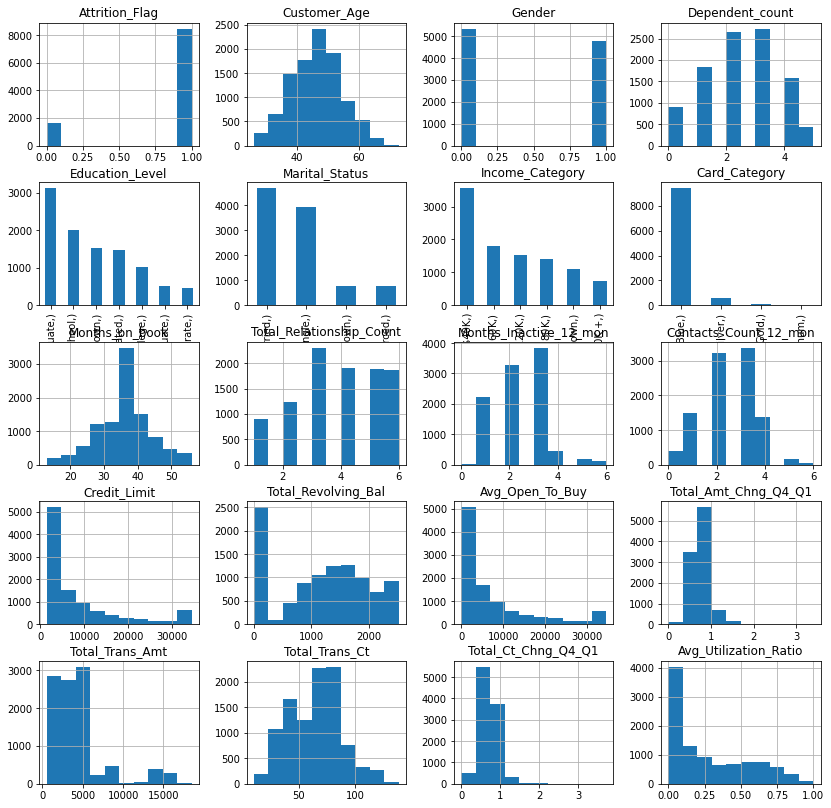

In [3]:
"""
Note: 
    The pymasq `bank-attrition-rates` dataset has already been cleaned 
    NaNs, unecessary columns, and had some discrete values binarized, so no additional
    data cleaning/processing is required during this step.
"""
ncols = 4
nrows = (orig_df.shape[1] + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 14))
i, j = 0, 0
for idx, col in enumerate(orig_df.columns):
    if idx != 0 and idx % 4 == 0:
        i += 1
        j = 0
    ax = axes[i, j]
    try:
        if is_numeric_dtype(orig_df[col]):
            orig_df[[col]].hist(ax=ax)
        else:
            orig_df[[col]].value_counts().plot.bar(title=col, ax=ax)
    except: 
        pass

    j += 1
        
plt.show()

### Step 3
_Identify a Sensitive Variable (SV) which you intend to remove and who's relationship amongst remaining data features (columns) you wish to obfuscate. Currently, a SV must be categorical/discrete._

This step relies heavily on the user's specific data use case and it is assumed the user
knows what variable (i.e., feature/column) needs to be protected, and therfore, 
considered a Sensitive Variable. 

For more information on Sensitive Variables, refer to: [TODO: LINK]

In [4]:
# Our scenario states that `Marital Status` cannot be released, and is therefore a 
# Sensitive Variable 
SV = "Marital_Status"
xo = orig_df.copy()         # original
xo = xo.drop(SV, axis=1)    # remove `Marital Status`

### Step 4
_Perform regression or classification task on original dataset, having removed the SV feature._

This step performs the defined classification task. 

We use a `RandomForestClassifier` trained via Strattified Cross Validation. The latter
choice addresses the class imbalance for the `Attrited_Flag` variable during training.

> Note that neither of these models may be optimal for the task and neither have had 
their parameters optimized. Performance may differ with different models and/or Cross 
Validation strategy.

In [5]:
# Utility function to evaluate classification performance
def eval_classifier(x):
    y = x.pop(AF)

    # `pymasq`'s `EmbeddingsEncoder` can automatically encode discrete as numeric features.
    # for more informations, pleease review the `pymasq.preprocessing.EmbeddingsEncoder` docs [TODO: LINK]
    x = EmbeddingsEncoder().encode(x) 

    clf = RandomForestClassifier(random_state=1)
    cv = StratifiedShuffleSplit(n_splits=4, test_size=0.3, random_state=1)

    scoring_metrics = (
        "accuracy", "balanced_accuracy", "f1", "f1_weighted", "f1_macro",
        "precision", "precision_macro", "precision_weighted", 
        "recall", "recall_macro", "recall_weighted", "roc_auc",
    )

    scores_df = pd.DataFrame(cross_validate(clf, x, y, cv=cv, scoring=scoring_metrics))

    avg_cv_scores = pd.Series(
        data=[f"{mean:.4f} +/- {std:.4f}" for mean, std in zip(scores_df.mean(), scores_df.std())], 
        index=scores_df.columns, 
        name="Average CV Scores"
    )
    
    return avg_cv_scores

In [6]:
# Note: Run `Step 3` before running or re-running this Step.
# These results are the scores to beat in Step 8.
eval_classifier(xo)

fit_time                   0.8637 +/- 0.0195
score_time                 0.1267 +/- 0.0059
test_accuracy              0.9526 +/- 0.0048
test_balanced_accuracy     0.8777 +/- 0.0158
test_f1                    0.9722 +/- 0.0027
test_f1_weighted           0.9508 +/- 0.0054
test_f1_macro              0.9054 +/- 0.0110
test_precision             0.9569 +/- 0.0056
test_precision_macro       0.9408 +/- 0.0040
test_precision_weighted    0.9518 +/- 0.0048
test_recall                0.9880 +/- 0.0011
test_recall_macro          0.8777 +/- 0.0158
test_recall_weighted       0.9526 +/- 0.0048
test_roc_auc               0.9846 +/- 0.0009
Name: Average CV Scores, dtype: object

> Note: Steps 5 - 7 are performed in `sdc-analysis.ipynb` and are skipped in this notebook

### Step 8
_Perform regression or classification task on modified dataset, having removed the SV feature._

Here, we load the modified datasets that were created in `sdc-analysis.ipynb`:
- `manual-mod-bank-attrition-rates.csv`
- `auto-mod-bank-attrition-rates.csv`

We then train the same `RandomForestClassifier` model on the modified dataset and 
compare its performance with the original model shown in `Step 4`, above.

In [7]:
xm_manual = pd.read_csv("manual-mod-bank-attrition-rates.csv")
xm_auto = pd.read_csv("auto-mod-bank-attrition-rates.csv")

xm_manual = xm_manual.drop(SV, axis=1)
xm_auto = xm_auto.drop(SV, axis=1)

In [8]:
eval_classifier(xm_manual)

fit_time                   0.9472 +/- 0.0188
score_time                 0.1255 +/- 0.0040
test_accuracy              0.9597 +/- 0.0035
test_balanced_accuracy     0.8875 +/- 0.0136
test_f1                    0.9764 +/- 0.0020
test_f1_weighted           0.9579 +/- 0.0040
test_f1_macro              0.9189 +/- 0.0082
test_precision             0.9596 +/- 0.0051
test_precision_macro       0.9602 +/- 0.0056
test_precision_weighted    0.9598 +/- 0.0033
test_recall                0.9938 +/- 0.0024
test_recall_macro          0.8875 +/- 0.0136
test_recall_weighted       0.9597 +/- 0.0035
test_roc_auc               0.9886 +/- 0.0019
Name: Average CV Scores, dtype: object

In [9]:
eval_classifier(xm_auto)

fit_time                   0.9477 +/- 0.0327
score_time                 0.1147 +/- 0.0029
test_accuracy              0.9743 +/- 0.0024
test_balanced_accuracy     0.9317 +/- 0.0060
test_f1                    0.9849 +/- 0.0014
test_f1_weighted           0.9738 +/- 0.0025
test_f1_macro              0.9503 +/- 0.0049
test_precision             0.9754 +/- 0.0021
test_precision_macro       0.9717 +/- 0.0035
test_precision_weighted    0.9742 +/- 0.0025
test_recall                0.9945 +/- 0.0008
test_recall_macro          0.9317 +/- 0.0060
test_recall_weighted       0.9743 +/- 0.0024
test_roc_auc               0.9951 +/- 0.0010
Name: Average CV Scores, dtype: object

### Conclusion
As in this notebook and `sdc-analysis.ipynb`, we were succesfully able to mitigate the 
attribute disclosure risk associated with `Marital Status`, the Sensitive Variable, 
while still maintaining the overall utility of the data, as shown by the classifier's 
performance, both in the manual (`xm_manual`) and automated (`xm_auto`) case, to predict
attrition rates.